In [1]:
%matplotlib inline

import os, pathlib
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from collections import Counter
import seaborn as sns
import pyaldata as pyal
from scipy.stats import wilcoxon

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import ccaTools as cca
        
        import params
        random_walk_defs = params.random_walk_defs
        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

FIGPATH = params.figPath / 'fig3'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


### Get data

In [2]:
defs = random_walk_defs
MCx_list, allDFs_MCx, allDFs_exec_MCx = dt.get_full_random_walk_data(GoodDataList_RW)
paired_dfs = dt.get_paired_dfs(GoodDataList_RW, MCx_list, allDFs_MCx, allDFs_exec_MCx)
# print(f'{len(paired_dfs)=}')

#example/ref session
ex_file = defs.ex_file
ref_file = defs.ref_file

#paired
ex_file_idx = [file for file,x,y in paired_dfs].index(ex_file)
print(ex_file_idx, ex_file)

#unpaired
i = [y for x,y in MCx_list].index(ex_file)
print('ex', i, ex_file)
ex_reaches_df = allDFs_exec_MCx[i]

i = [y for x,y in MCx_list].index(ref_file)
print('ref', i , ref_file)
ref_reaches_df = allDFs_exec_MCx[i]

Mihili_RT_VR_2014-01-15.mat 147 diff target groups
28 target groups left
Mihili_RT_FF_2014-02-24.mat 123 diff target groups
20 target groups left
Mihili_RT_VR_2014-01-14.mat 137 diff target groups
28 target groups left
Mihili_RT_FF_2014-02-14.mat 129 diff target groups
26 target groups left
Mihili_RT_FF_2014-02-21.mat 131 diff target groups
22 target groups left
Mihili_RT_VR_2014-01-16.mat 124 diff target groups
21 target groups left
MrT_RT_FF_2013-08-22.mat 152 diff target groups
29 target groups left
MrT_RT_FF_2013-08-30.mat 123 diff target groups
16 target groups left
MrT_RT_FF_2013-08-20.mat 97 diff target groups
14 target groups left
MrT_RT_VR_2013-09-10.mat 135 diff target groups
28 target groups left
2 Mihili_RT_VR_2014-01-14.mat
ex 12 Mihili_RT_VR_2014-01-14.mat
ref 1 Chewie_RT_CS_2016-10-21.mat


### Fig 3B: Example raw monkey reaches

Mihili_RT_VR_2014-01-14
Chewie_RT_CS_2016-10-21


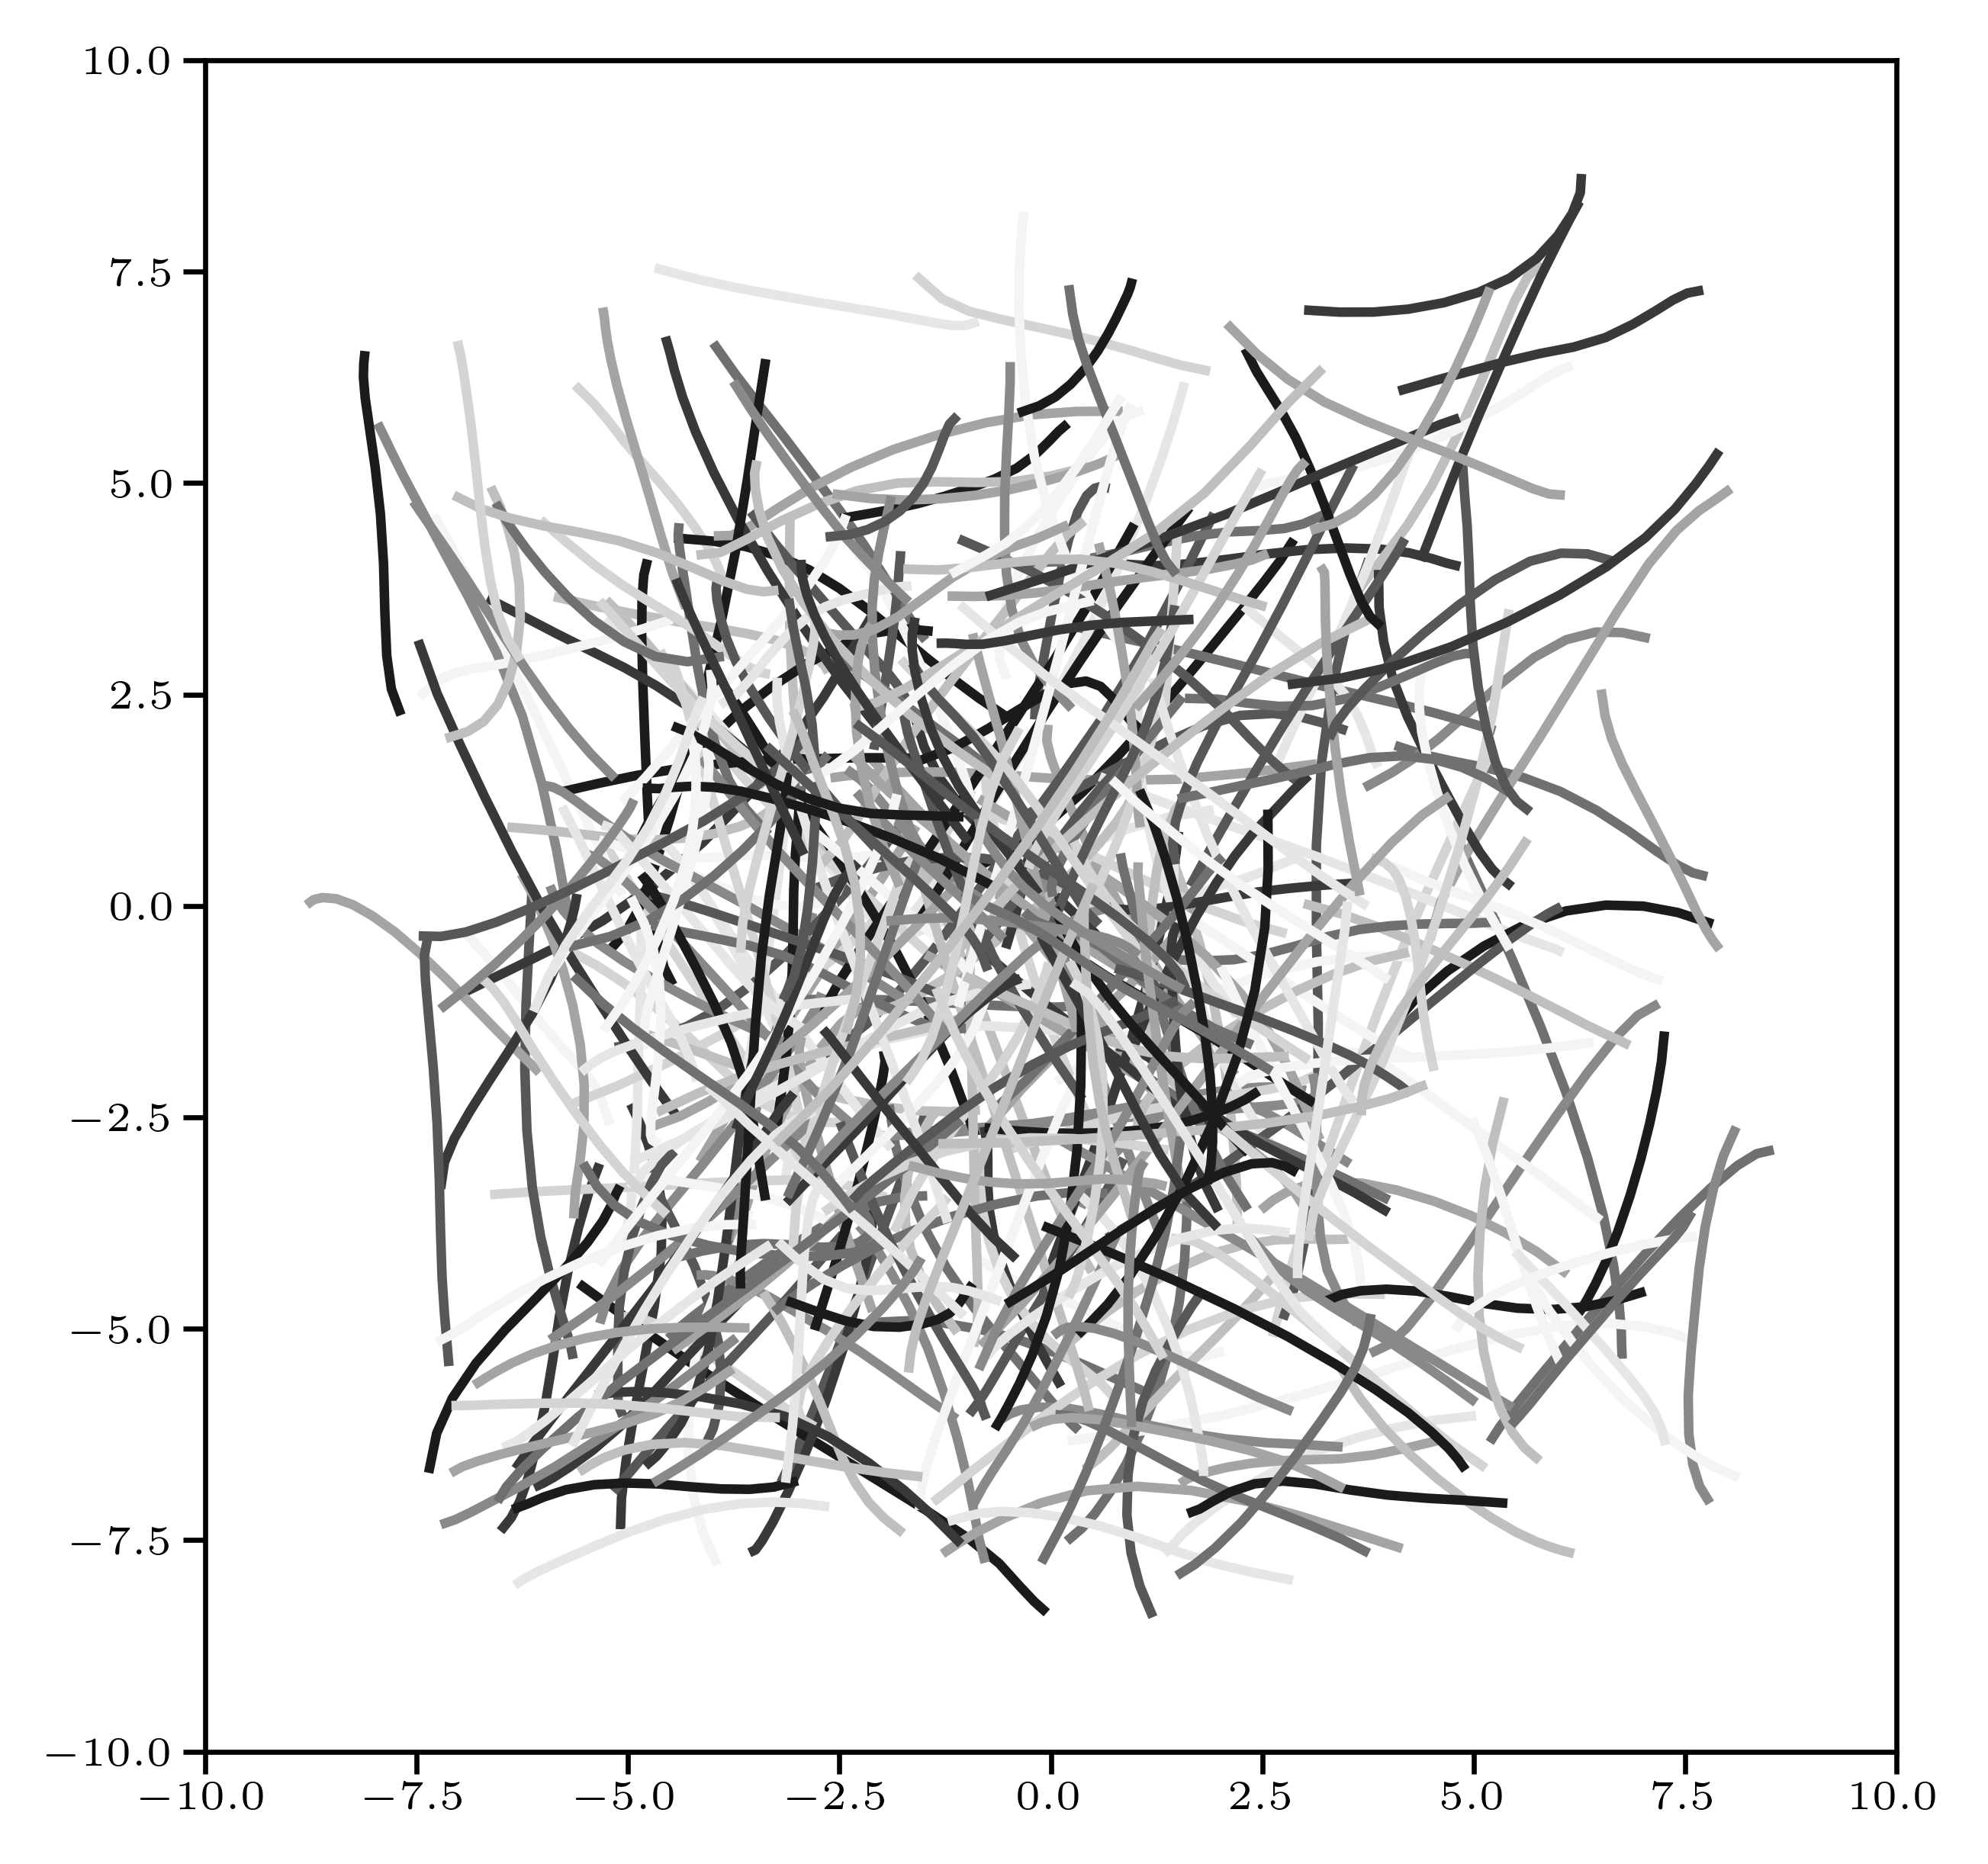

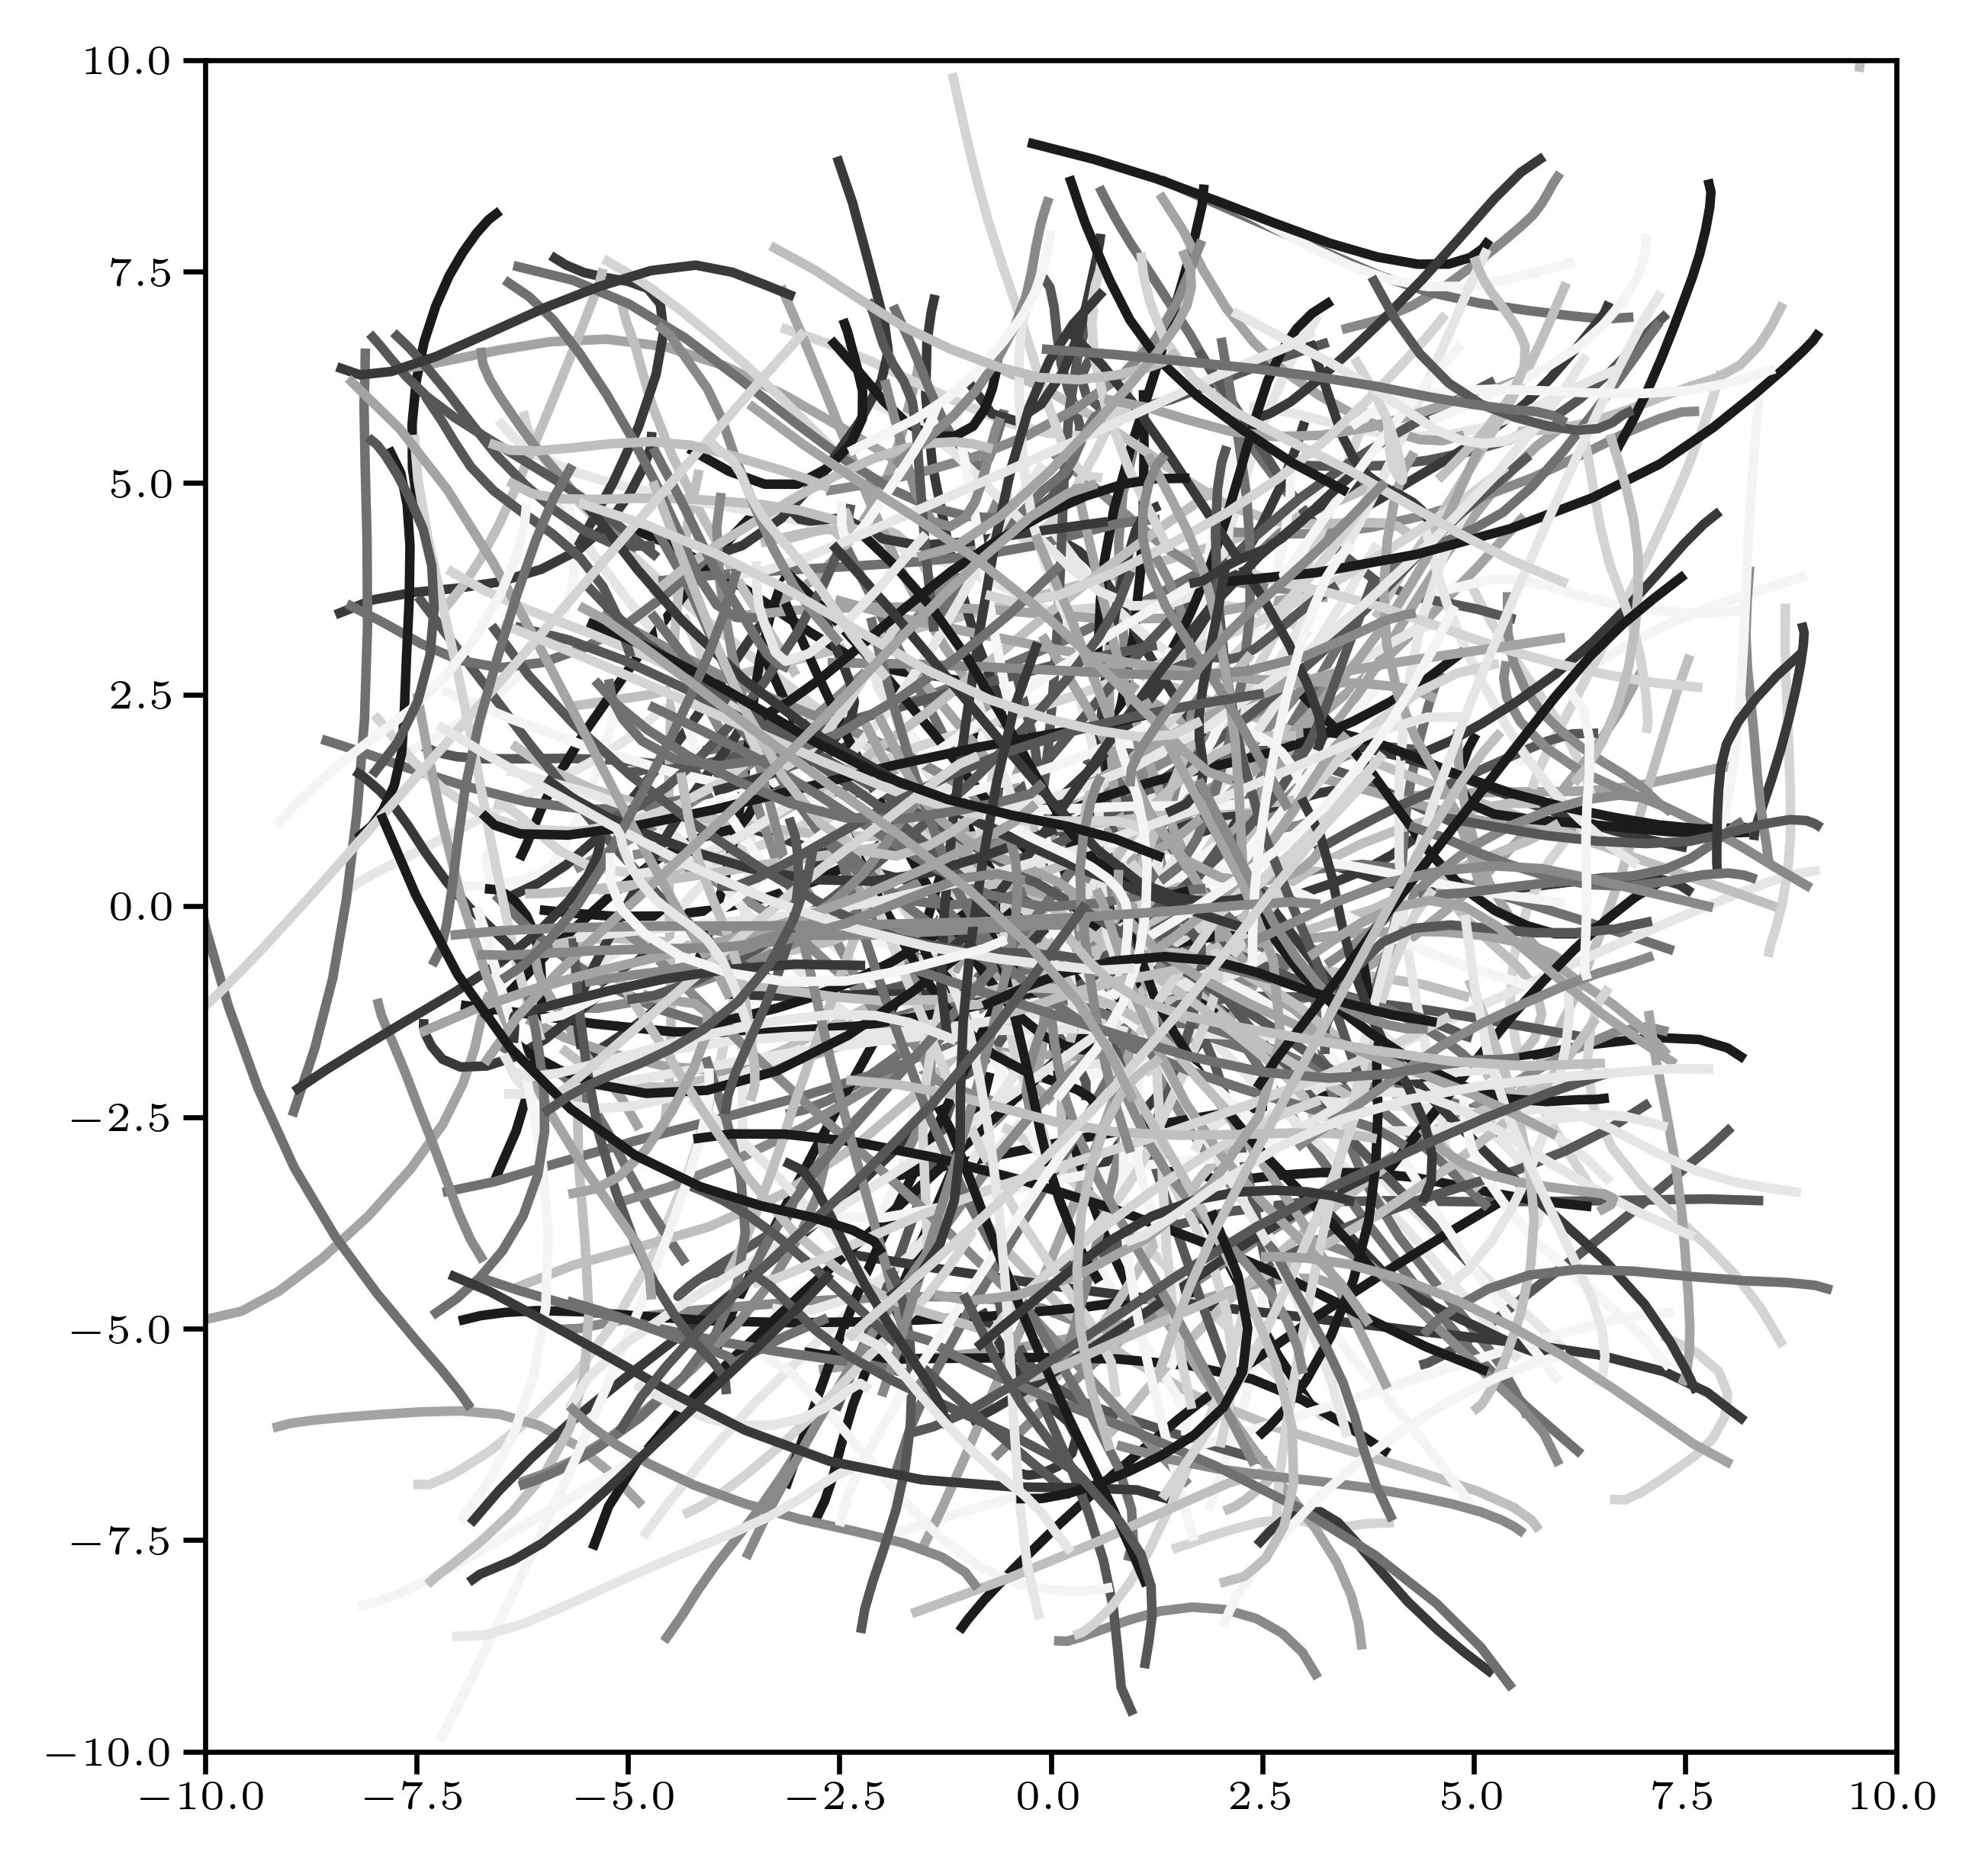

In [3]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)

#plot reaches for both reference and example file
for file, df in [(ex_file, ex_reaches_df), (ref_file,ref_reaches_df)]:
    #subset reaches that start around the center, movement only
    ntrials = len(df)
    plt.figure()
    with sns.color_palette("Greys", n_colors=10):
        for i in range(ntrials):
            pos = df.pos.values[i]
            # targets = exec_df.target_centered.values[i]
            angle = df.target_angle.values[i]
            plt.plot(*pos[:].T)
            # plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
    plt.gca().set_aspect(1)
    plt.xlim([-10,10])
    plt.ylim([-10,10])

    file_name = file[:-4]
    print(file_name)
    info = '_'.join([file_name])
    plt.savefig(FIGPATH / ('RW-reaches-' + info + '.pdf'), format= 'pdf')

### Fig 3C: Example matched monkey reaches

<Figure size 3840x2880 with 0 Axes>

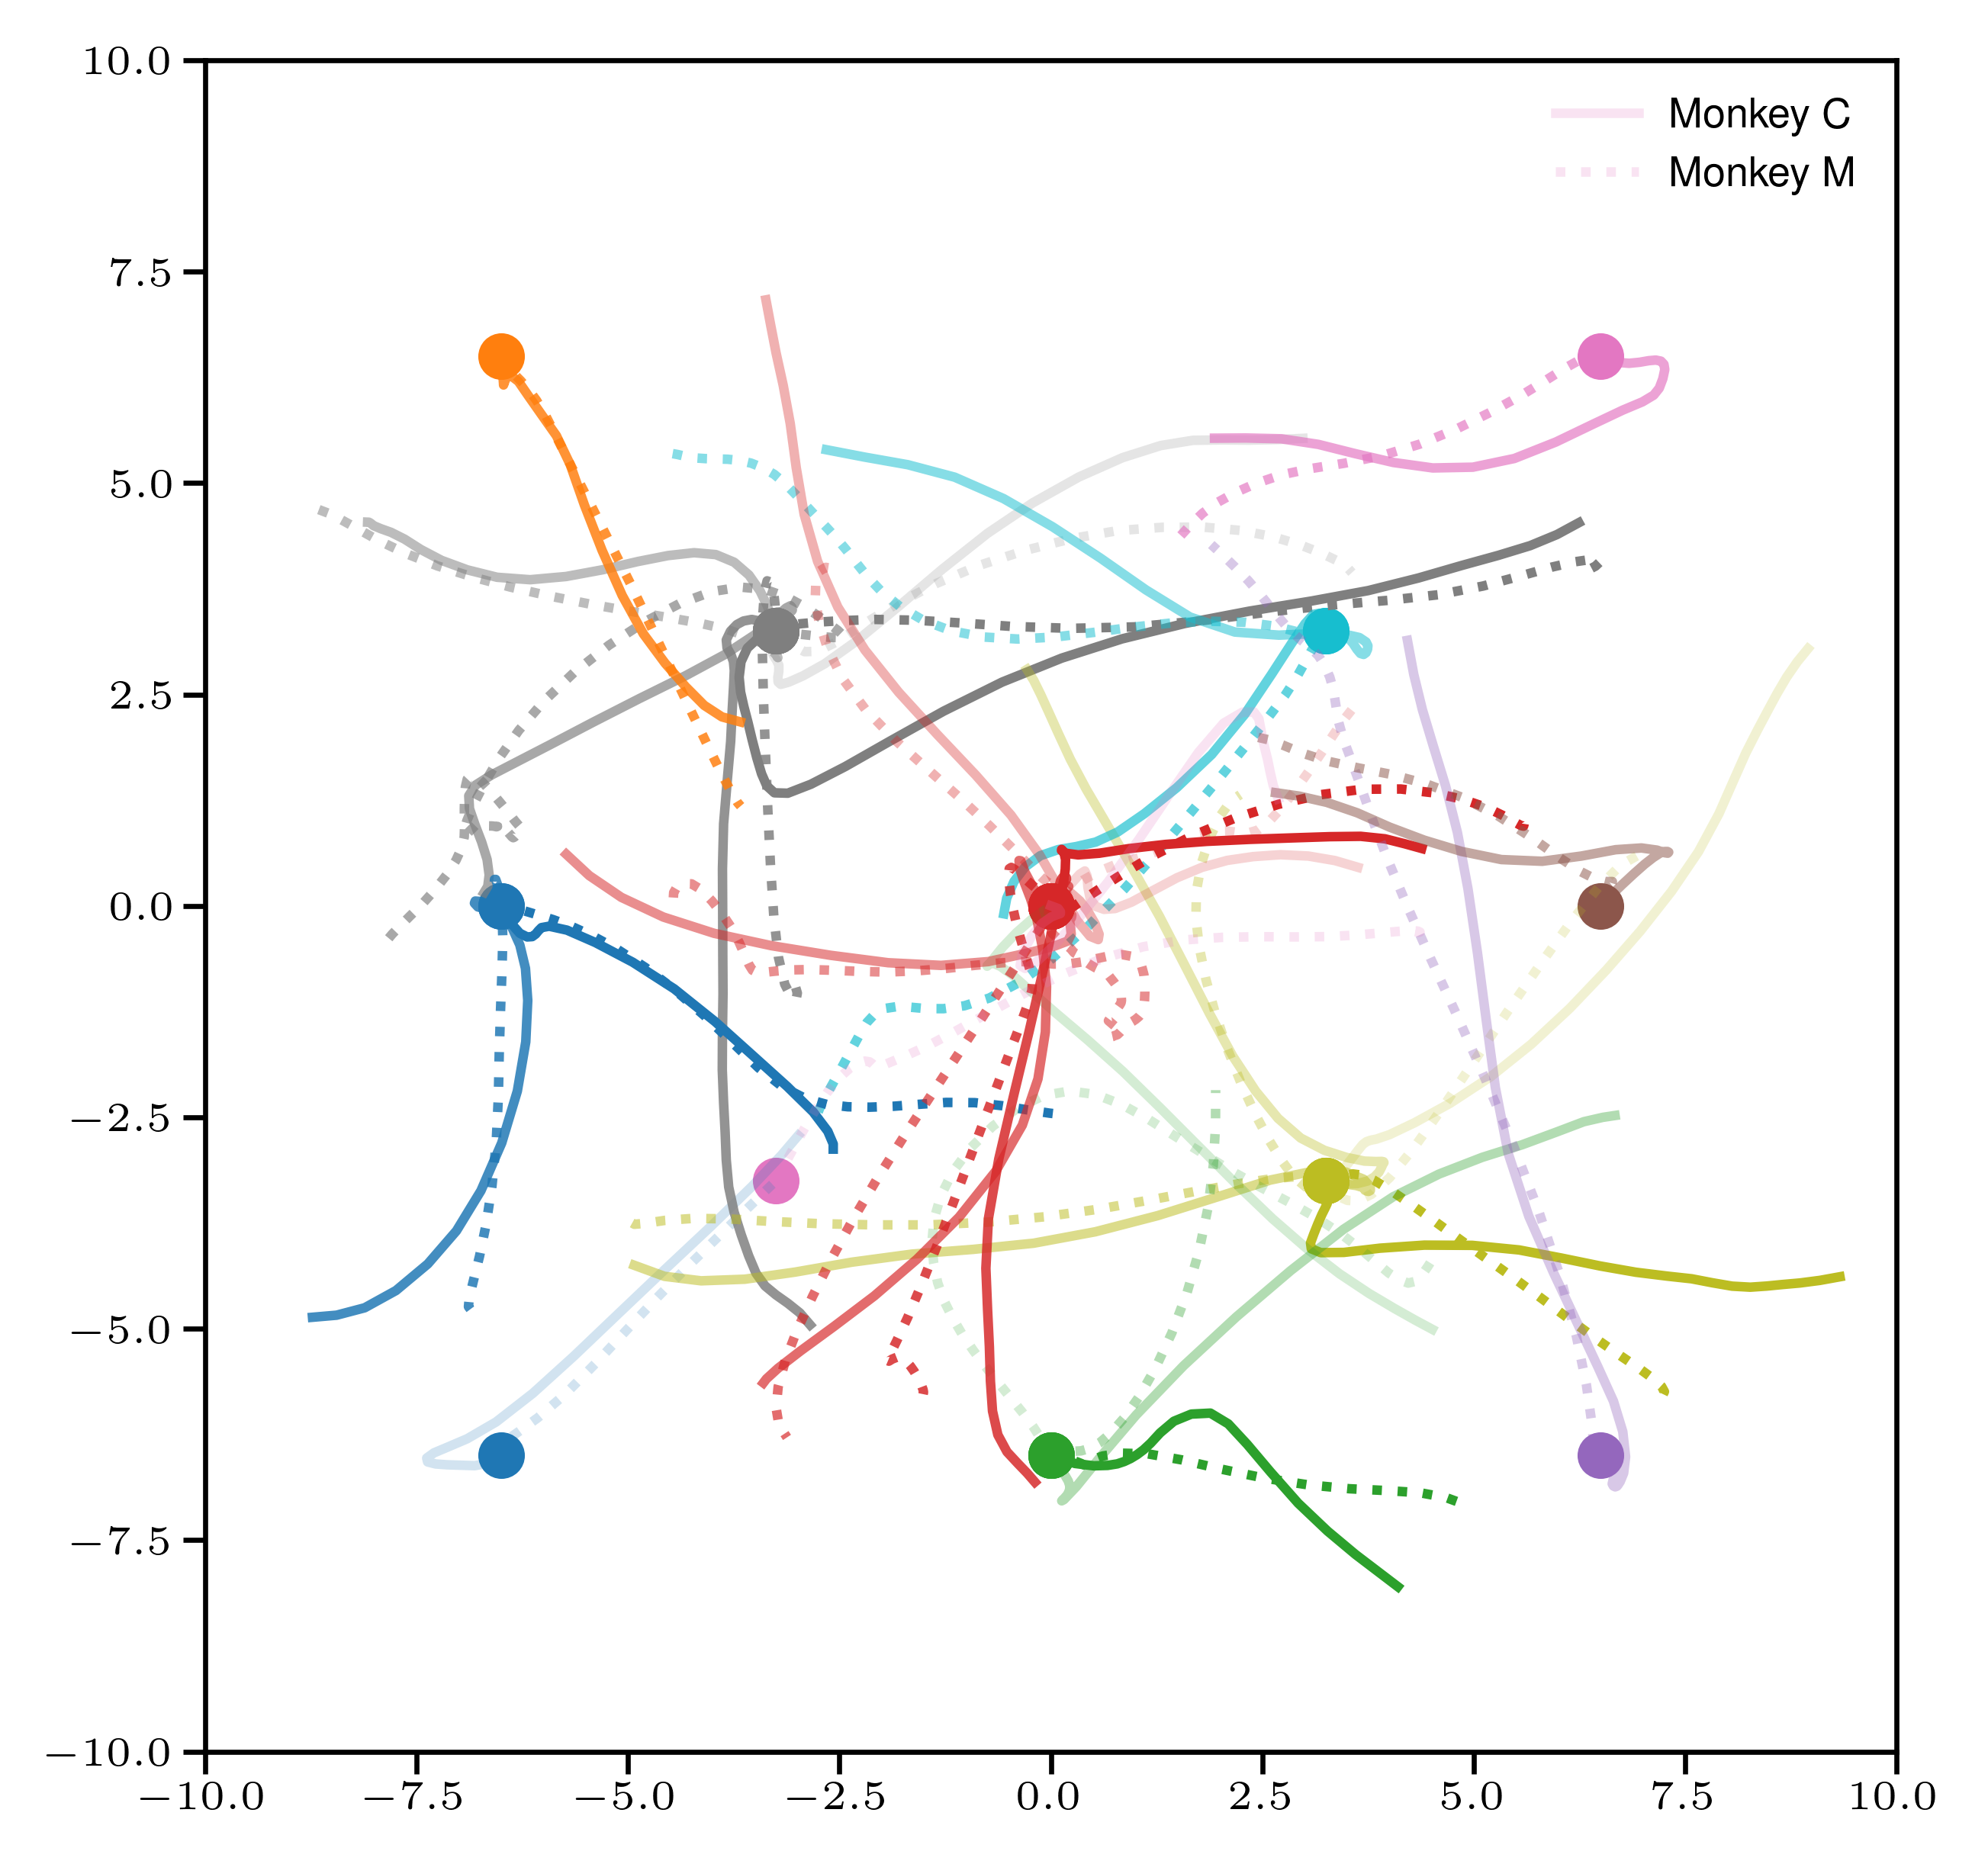

In [4]:
ex_file, df1_, df2_ = paired_dfs[ex_file_idx]

#plot matched reaches
plt.figure()
ntrials = 10
colors = utility.get_colors(13, 'tab10')
alphas = np.linspace(0.2,1,defs.n_angle_groups)
# alphas = np.ones(defs.n_angle_groups)
target_groups = defs.target_groups
plt.figure()
df = df1_

subset_target_groups = np.unique(df1_.target_group)

center_ids = []
for tar in subset_target_groups[:]:
    df1__ = df1_[df1_.target_group == tar]
    df2__ = df2_[df2_.target_group == tar]

    center_id = df2__.center_id.values[0]
    angle_group = df2__.angle_group.values[0]
    center_ids.append(center_id)
    center = df2__.center.values[0]
    plt.scatter(center[0], center[1], s = 40, c= colors[center_id])

    for i in range(1):
        pos = df1__.pos_centered.values[i]
        plt.plot(*pos[:].T, c=colors[center_id], label = 'Monkey C', alpha = alphas[angle_group])

        pos = df2__.pos_centered.values[i]
        plt.plot(*pos[:].T, c=colors[center_id], linestyle = 'dotted', label = 'Monkey M', alpha = alphas[angle_group])

plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])

info = '_'.join([file_name])
plt.savefig(FIGPATH / ("RW-paired_reaches_all_targets"+info+'.pdf'), format='pdf')

### Fig 3D: Example CCA

In [5]:
def get_alignments(df1, df2):
    allCCs=[]
    CCsL=[]
    CCsU=[]
    
    subset_target_groups = np.unique(df1.target_group)

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1, df2, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #1 x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(cca.canoncorr(data1, data2))
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(cca.canoncorr(data1, data2))
        CCsL.append(r)
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(cca.canoncorr(data1, data2))
        CCsU.append(r)
    
    return allCCs, CCsL, CCsU

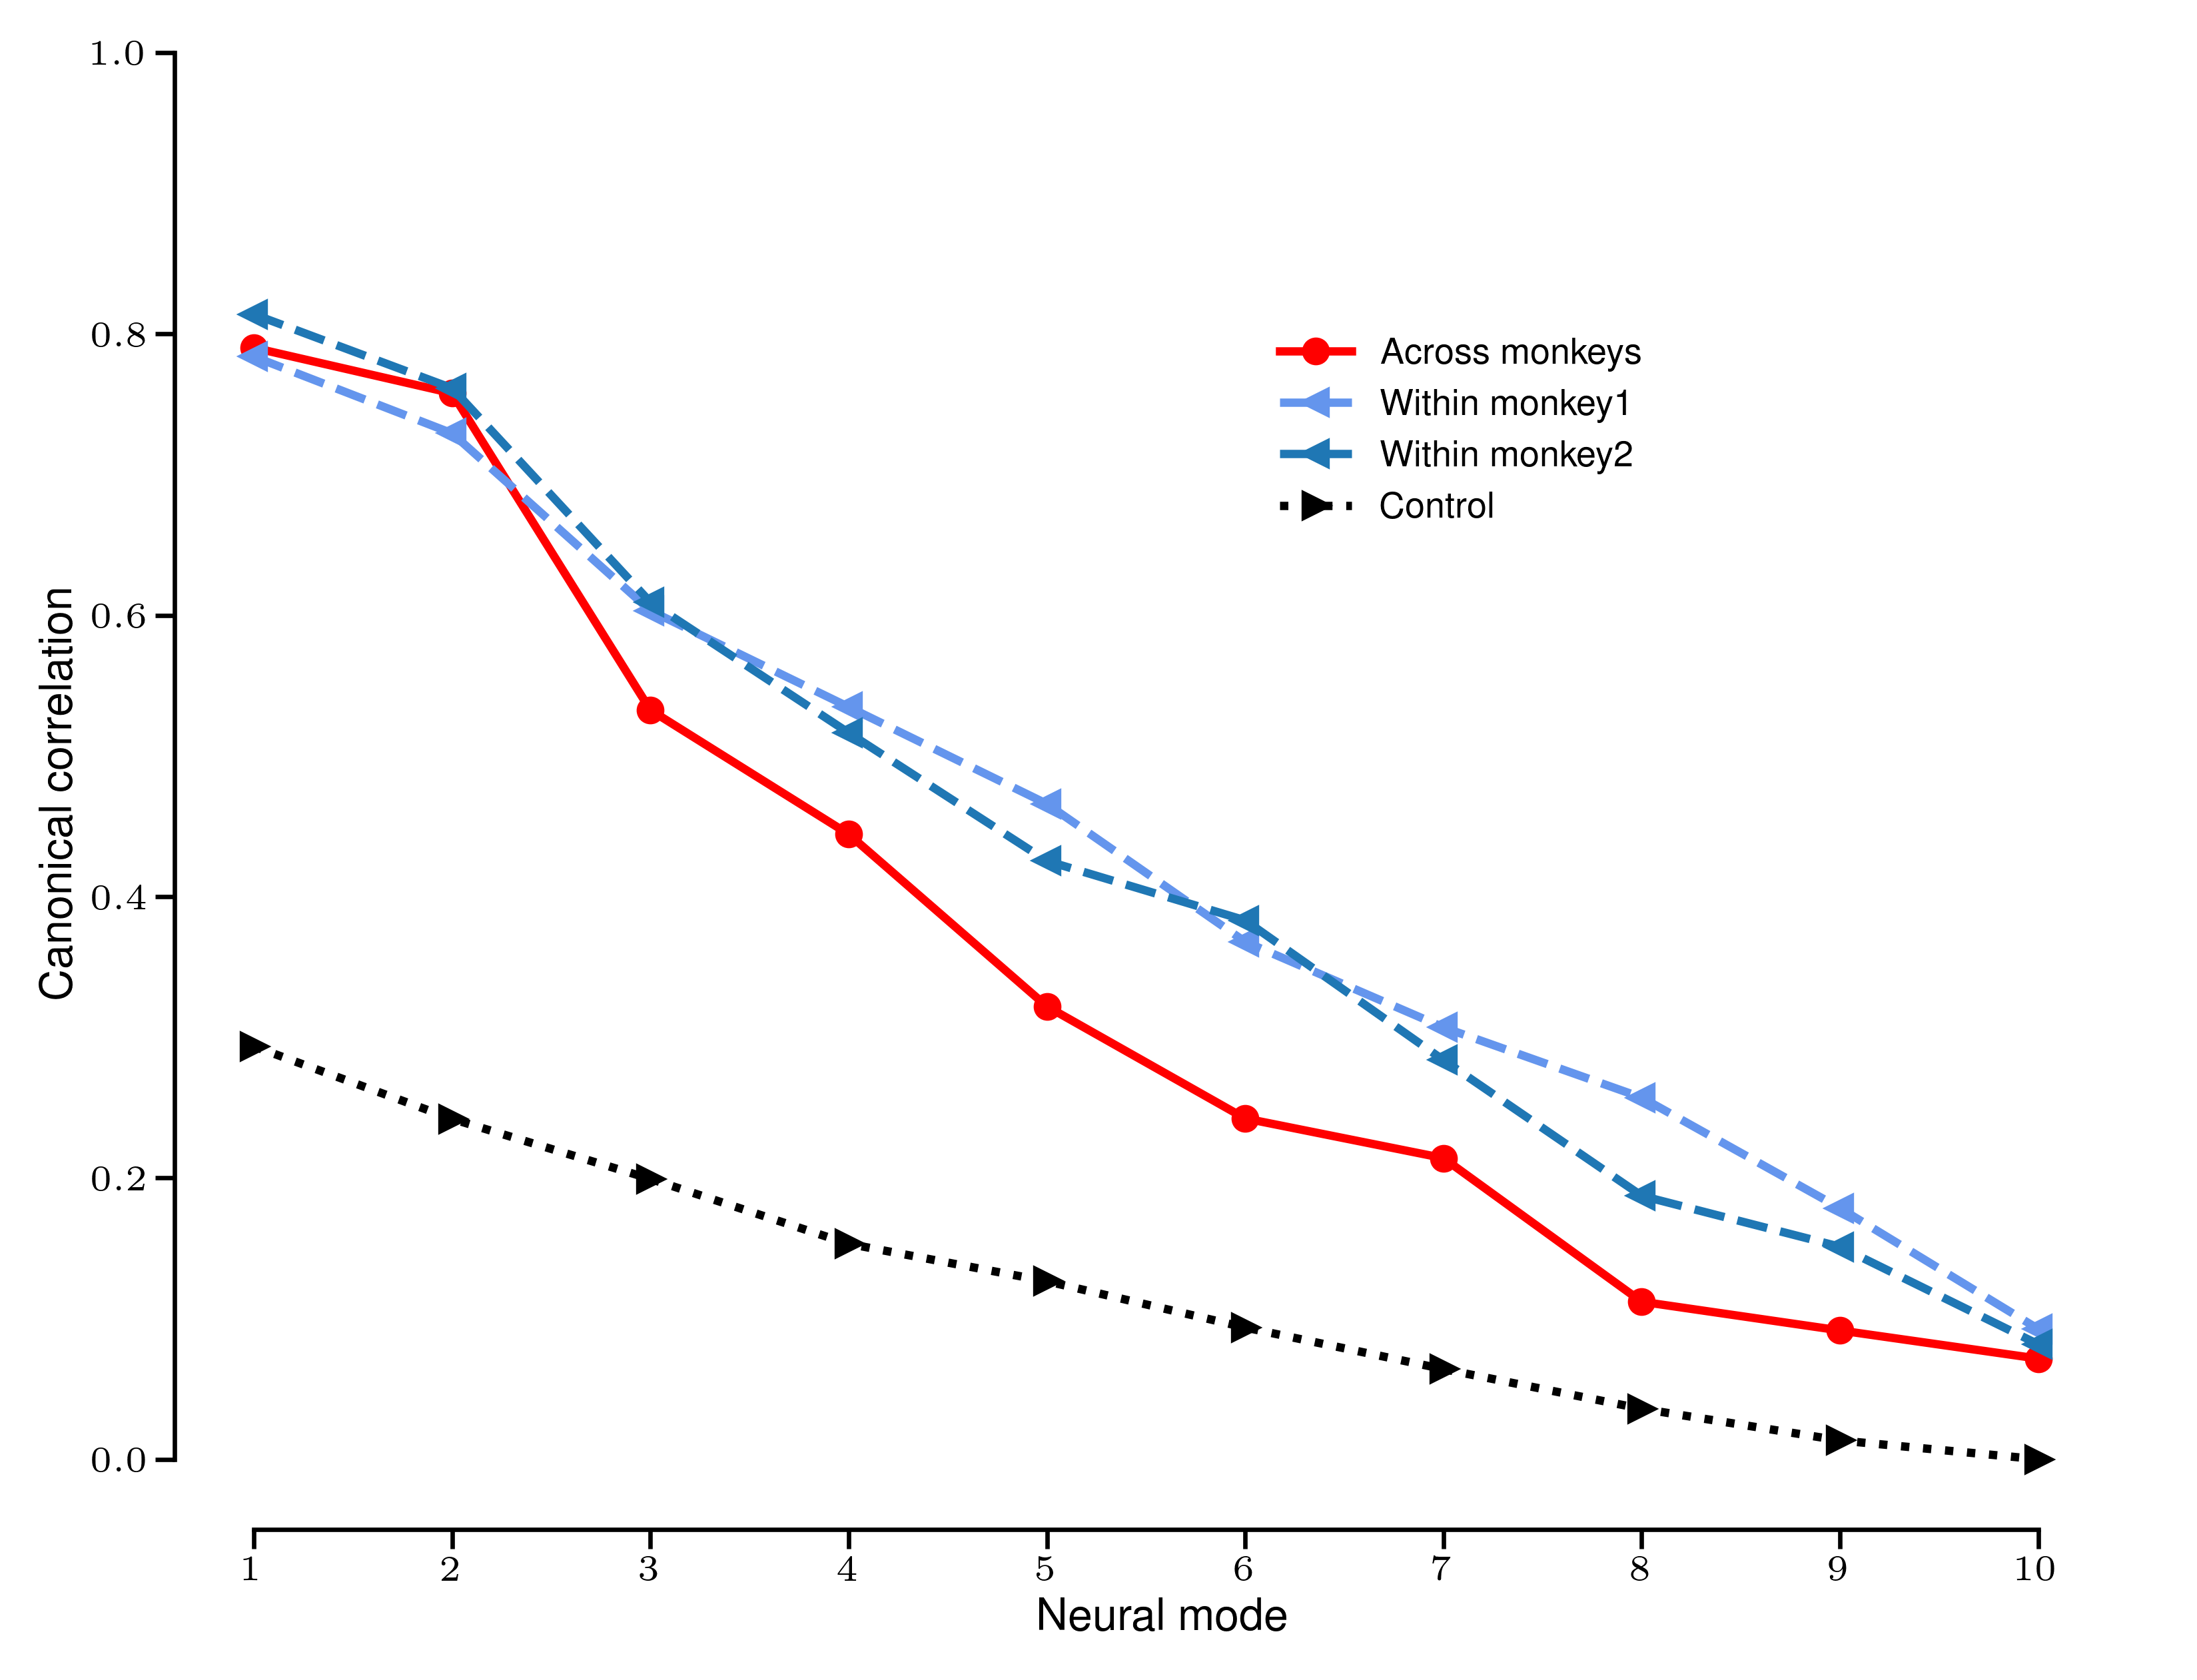

In [6]:
#cca
ex_file, df1_, df2_ = paired_dfs[ex_file_idx]
allCCs, CCsL, CCsU = get_alignments(df1_, df2_)

allCCs = np.array(allCCs).T
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
fig, ax = plt.subplots()
x_ = np.arange(1,defs.n_components+1)
ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')

ax.set_ylim([-.05,1])
ax.set_xlim([.6,defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_title(f'{defs.areas[2]} Alignment')
ax.legend(loc=(.55,.67))
ax.set_ylabel('Canonical correlation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])

info = '_'.join([ex_file[:-4]])

fig.savefig(FIGPATH / ('RW-CCA-' + info + '.pdf'), format='pdf', bbox_inches='tight')

### Fig 3E: CCA for all sessions

Across vs within: WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)
Across vs control: WilcoxonResult(statistic=0.0, pvalue=0.001953125)


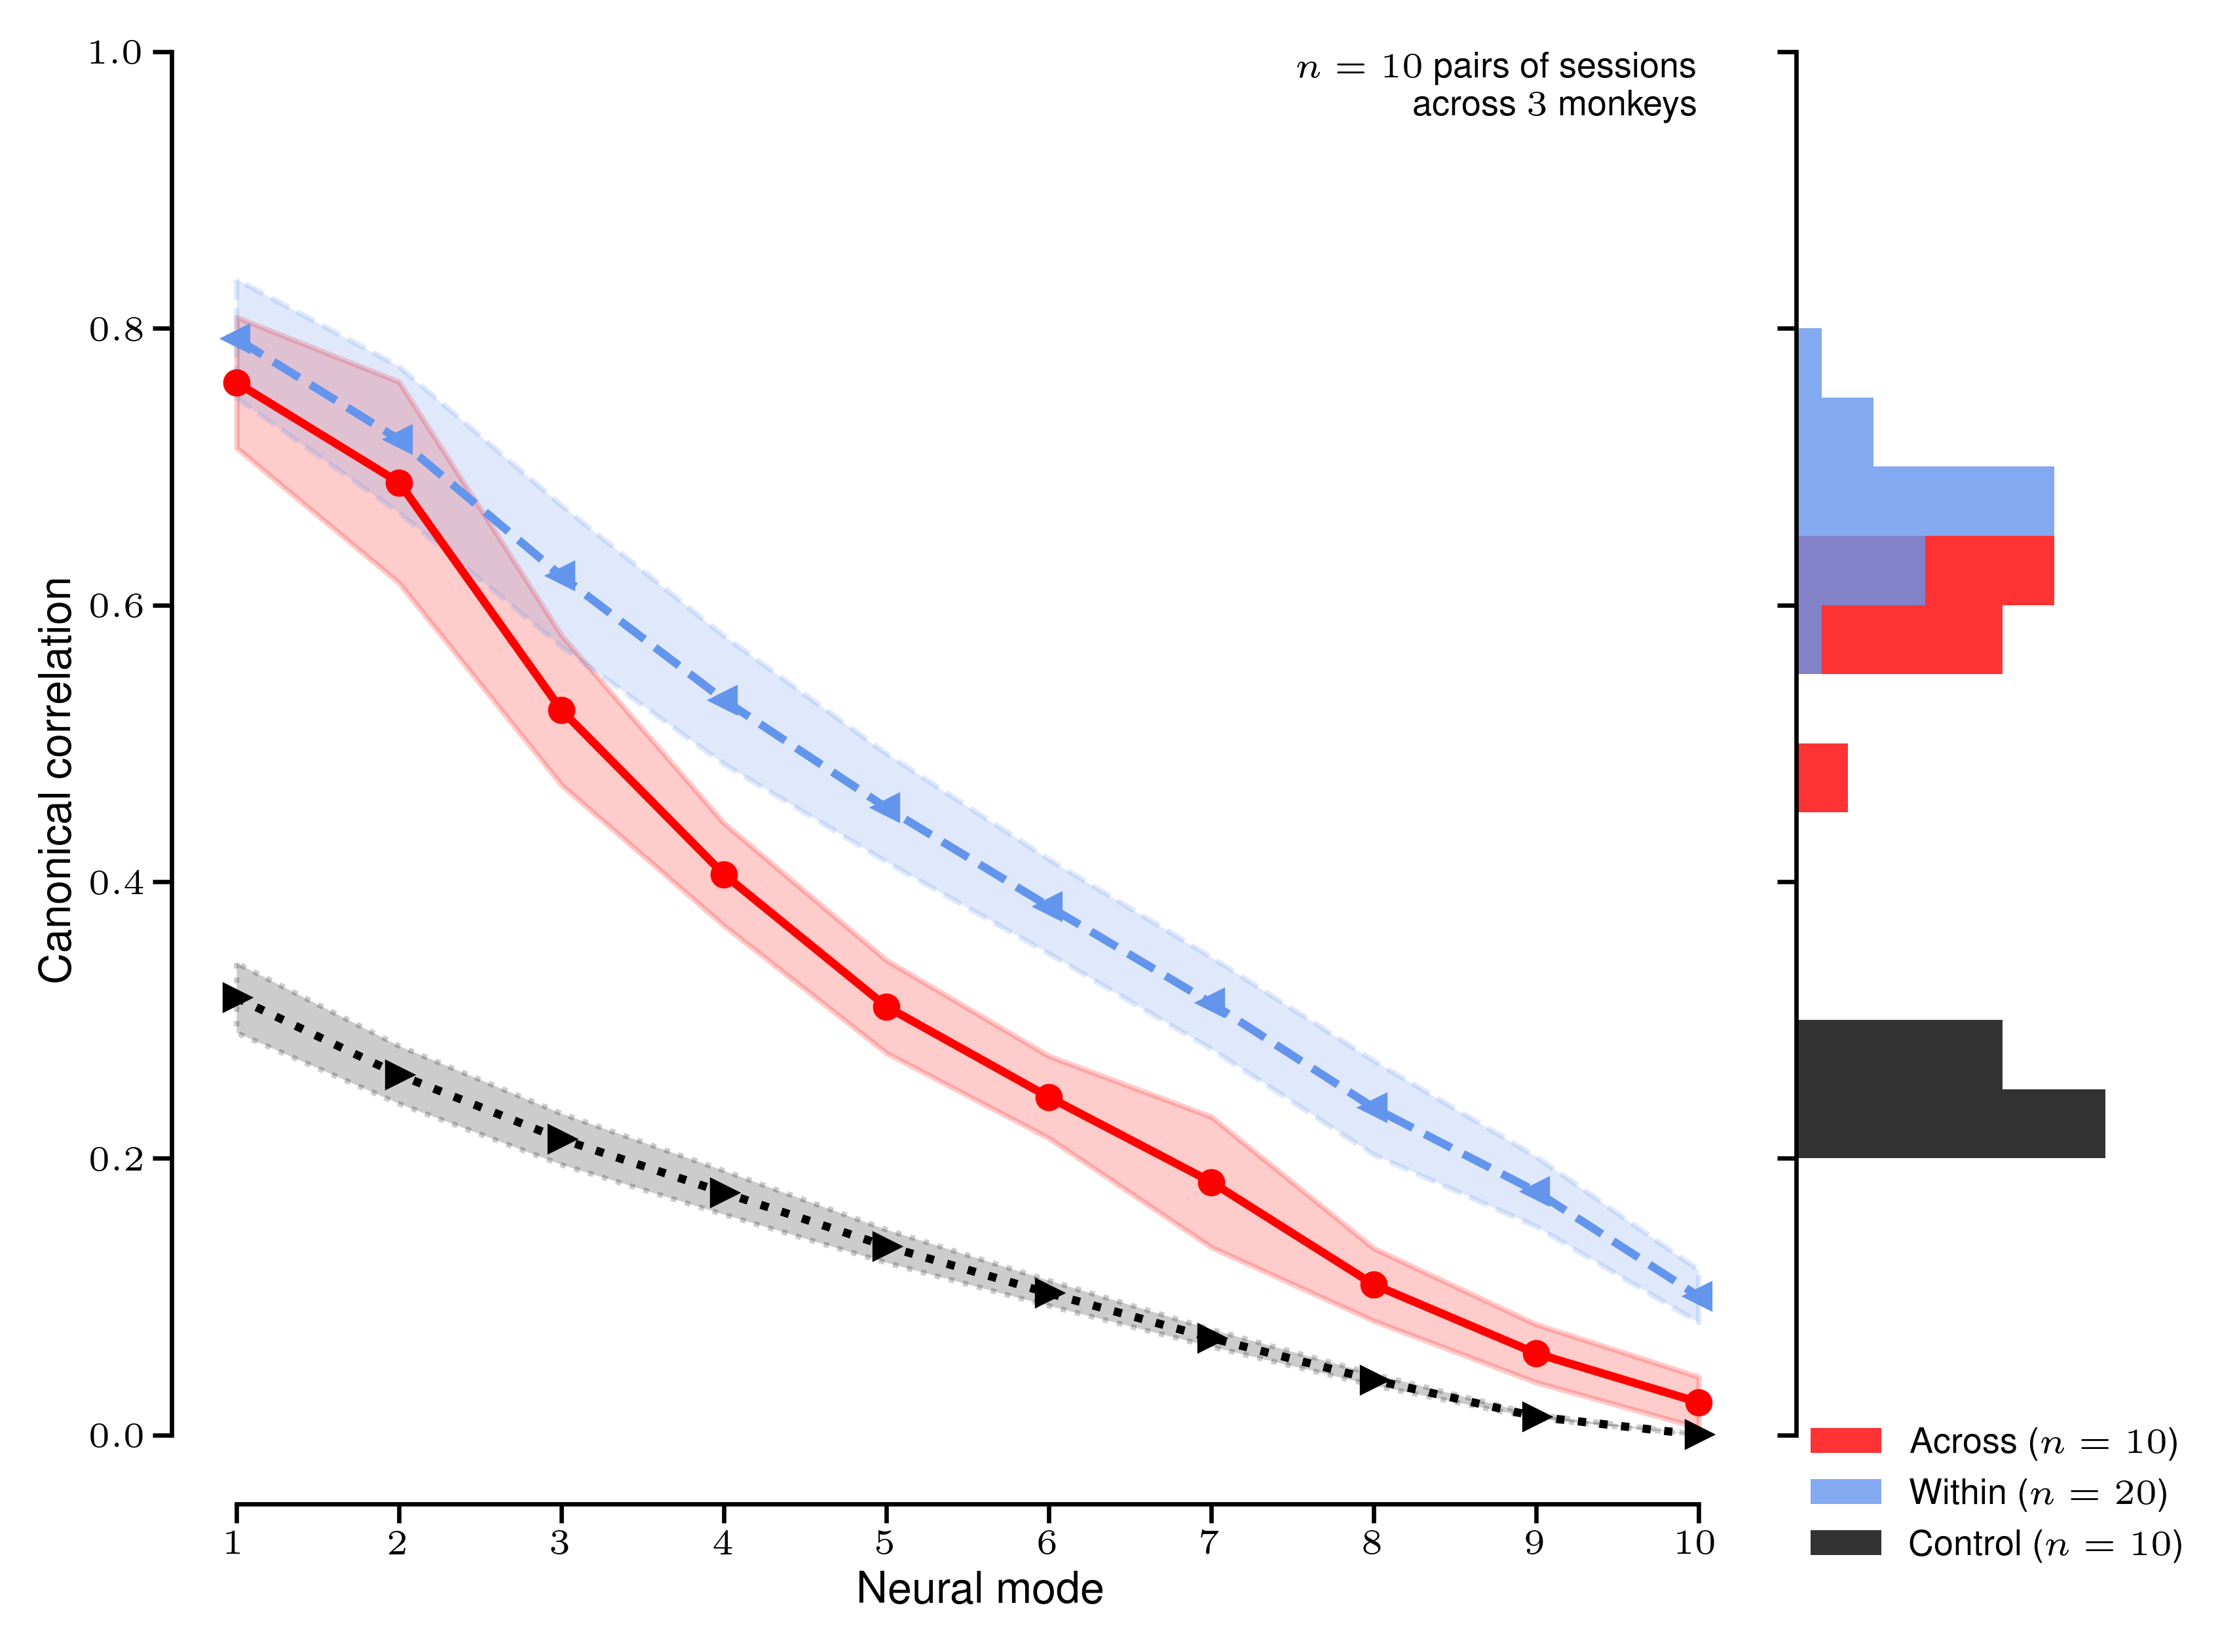

In [7]:
# get ccs
allCCs=[]
CCsL=[]
CCsU=[]

for ex_file, df1_, df2_ in paired_dfs:
    allCCs_, CCsL_, CCsU_ = get_alignments(df1_, df2_)

    allCCs.extend(allCCs_)
    CCsL.extend(CCsL_)
    CCsU.extend(CCsU_)

allCCs = np.array(allCCs).T
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])

x_ = np.arange(1,defs.n_components+1)
utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

ax.set_ylim([-.05,1])
ax.set_xlim([.6, defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Canonical correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])
ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
        ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])

bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))

allCCs_mean = allCCs[:4,:].mean(axis=0)
CCsU_mean = CCsU[:4,:].mean(axis=0)
CCsL_mean = CCsL[:4,:].mean(axis=0)

#calc stats
##for paired stats
compare_upper_stats = wilcoxon(np.repeat(allCCs_mean,2), CCsU_mean)
compare_lower_stats = wilcoxon(allCCs_mean, CCsL_mean)

print("Across vs within:", compare_upper_stats)
print("Across vs control:", compare_lower_stats)

fig.savefig(FIGPATH / 'RW-CCA.pdf', format='pdf', bbox_inches='tight')

### Fig 3F: CCA based on number of conditions


In [8]:
redo = False
import random
import itertools
from tqdm.auto import tqdm

subset_CCs = []
for ex_file, df1_, df2_ in paired_dfs:
    # if ex_file != 'Mihili_RT_VR_2014-01-14.mat': continue

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(cca.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    #get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_targets_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            allCCs_subset = pickle.load(f)
    else: 
        target_groups = np.unique(df1_.target_group)
        n_target_groups = len(target_groups)

        #remove n target groups
        allCCs_subset = []
        for n in tqdm(range(2,n_target_groups+1)):
            allCCs_subset_ = []
            comb = list(itertools.combinations(range(n_target_groups), n))
            # print(n, len(comb))
            comb = random.sample(comb, min(len(comb),10000)) #do max 10000 combos
            for target_idx in comb:
                AllData1_ = AllData1[:, target_idx,:,:,:]
                AllData2_ = AllData2[:, target_idx,:,:,:]

                for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
                    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    allCCs_subset_.append(cca.canoncorr(data1, data2))
            allCCs_subset.append(np.array(allCCs_subset_).T) 
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(allCCs_subset, f)   
    print(ex_file, len(allCCs_subset))
    subset_CCs.append(allCCs_subset)

Mihili_RT_VR_2014-01-15.mat 27
Mihili_RT_FF_2014-02-24.mat 19
Mihili_RT_VR_2014-01-14.mat 27
Mihili_RT_FF_2014-02-14.mat 25
Mihili_RT_FF_2014-02-21.mat 21
Mihili_RT_VR_2014-01-16.mat 20
MrT_RT_FF_2013-08-22.mat 28
MrT_RT_FF_2013-08-30.mat 15
MrT_RT_FF_2013-08-20.mat 13
MrT_RT_VR_2013-09-10.mat 27


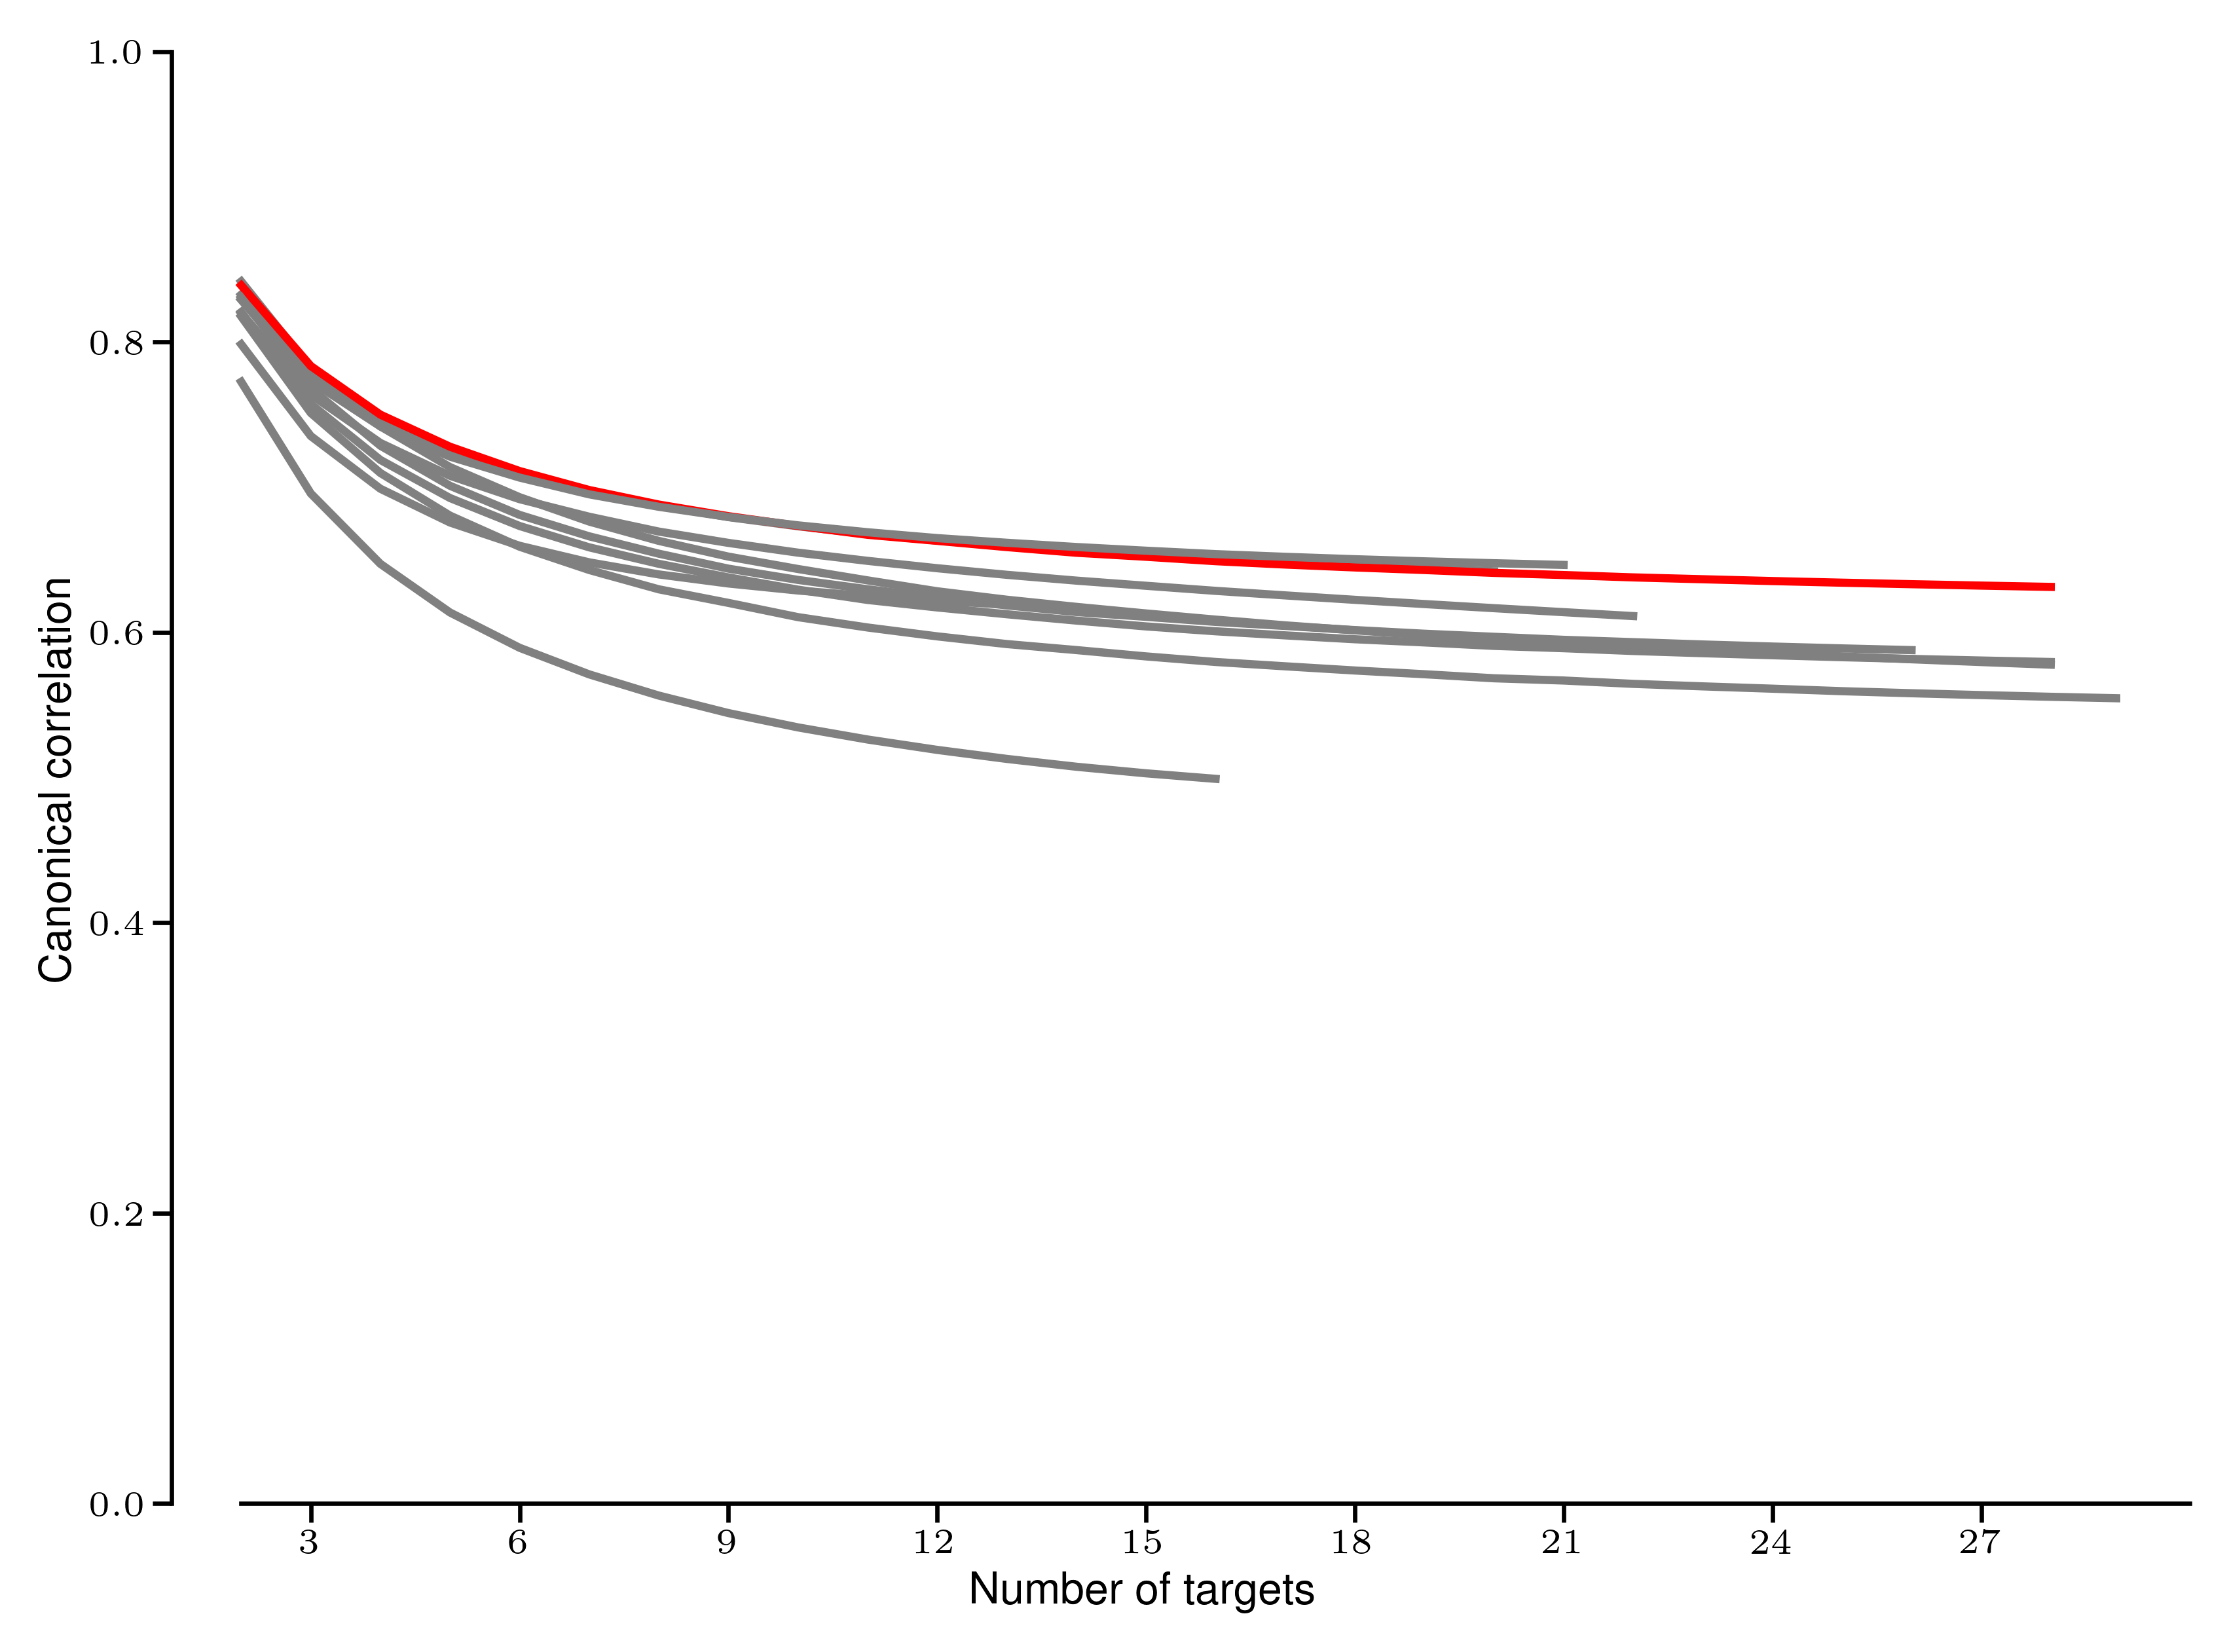

In [9]:
session_colors = utility.get_colors(len(subset_CCs))
fig, ax = plt.subplots()

for i, allCCs_subset in enumerate(subset_CCs):
    all_mean_ccs = [np.mean(x[:4],axis = 0) for x in allCCs_subset]
    mean_ccs = [np.mean(x) for x in all_mean_ccs]

    n_target_groups = len(mean_ccs)+2
    x = range(2, n_target_groups)
    colors = utility.get_colors(n_target_groups)

    if i == ex_file_idx:
        ax.plot(x, mean_ccs, c = 'red')
    else:
        ax.plot(x, mean_ccs, c = 'grey')

    plt.xlabel('Number of targets')
    plt.ylabel('Canonical correlation')
    plt.ylim([0,1])
    plt.xlim([1,29])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([2,30])
    ax.spines['left'].set_bounds([0,1])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    
info = '_'.join([str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
plt.savefig(FIGPATH / ("RW-mean_cca_subset_targets_"+info+'.pdf'), format= 'pdf')

### Fig 3G: CCA based on number of neurons

In [10]:
def keep_neurons(df, n_keep, signal):
    df_ = df.copy()
    n_neurons = df_[signal].values[0].shape[1]
    if n_neurons < n_keep:
        return False
    mask = params.rng.choice(n_neurons, n_keep, replace = False)
    df_[signal] = [arr[:, mask] for arr in df_[signal]]
    
    return df_

n_step = 10
n_per_removal = 10
def cca_sub_neurons_inc(df1, df2, ex_file, redo = False):
    # get saved ccs
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_neurons_keep_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            CC_corr_subsample = pickle.load(f)
    else: 

        #successively keep more neurons
        signal = defs.areas[2] + '_rates'

        n_neurons1 = df1[signal].values[0].shape[1]
        n_neurons2 = df2[signal].values[0].shape[1]
        
        n_iter = 50

        CC_corr_subsample = []
        for n_keep in range(defs.n_components+1, 1000, n_step):
            #remove neurons
            df1_ = keep_neurons(df1, n_keep, signal)
            df2_ = keep_neurons(df2, n_keep, signal)
            if df1_ is False or df2_ is False:
                break

            CC_corr=[]
            for j in tqdm(range(n_iter)):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        
                *_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
                data1 = np.reshape(AllData1[0,:min_trials,:min_time,:], (-1,defs.n_components))
                data2 = np.reshape(AllData2[0,:min_trials,:min_time,:], (-1,defs.n_components))
                CC_corr.append(cca.canoncorr(data1, data2)[:4].mean())
            CC_corr_subsample.append(np.array(CC_corr))
            # CC_corr_subsample.append(np.mean(CC_corr))
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(np.array(CC_corr_subsample), f)   
        
    return CC_corr_subsample


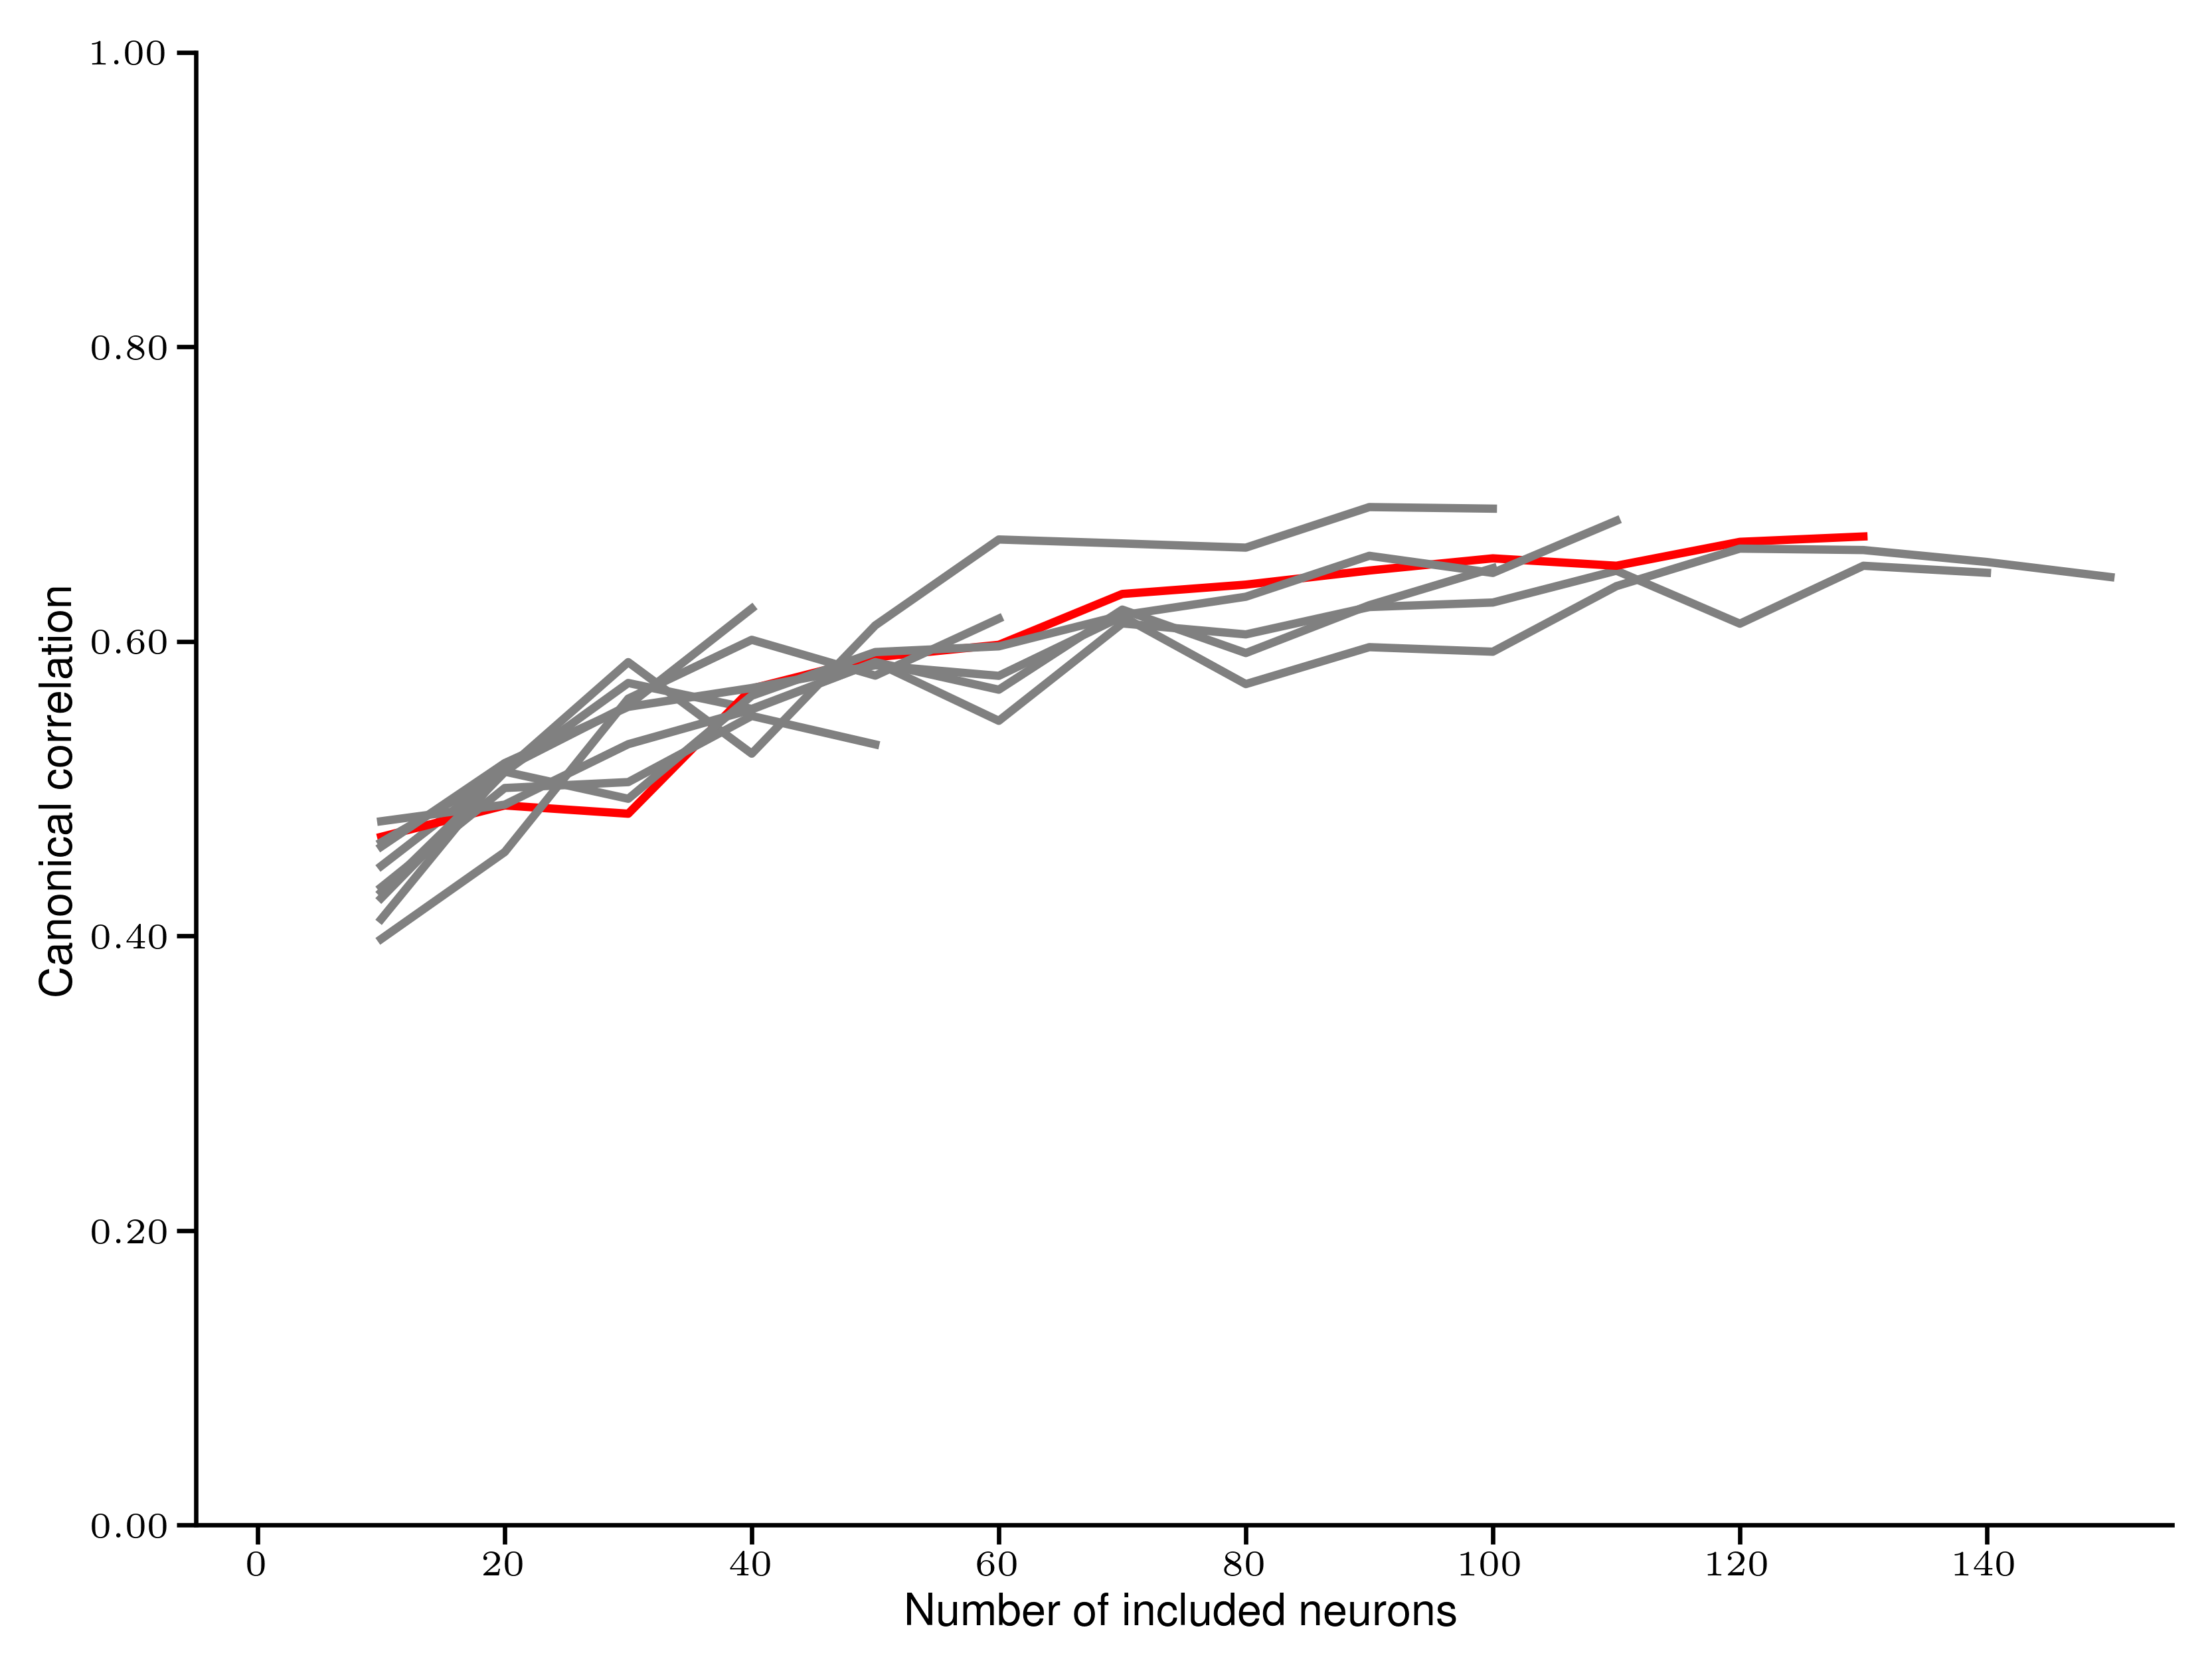

In [11]:
CC_corr_subsample= []
for ex_file, df1_, df2_ in paired_dfs:
    ccs = np.array(cca_sub_neurons_inc(df1_,df2_, ex_file,redo = False))
    mean_ccs = np.mean(ccs,axis=1)
    CC_corr_subsample.append(mean_ccs)

# Plotting
set_rc()
fig, ax = plt.subplots()

for i,cc in enumerate(CC_corr_subsample):
    if i == ex_file_idx:
        ax.plot((np.arange(len(cc))*n_step)+defs.n_components, np.array(cc), color=params.colors.MainCC)
    else: 
        ax.plot((np.arange(len(cc))*n_step)+defs.n_components, np.array(cc), color='grey')

ax.set_xlabel('Number of included neurons')
ax.set_ylabel('Canonical correlation')
ax.set_ylim([0,1])
ax.set_xlim([-.5*n_per_removal, max([len(cc) for cc in CC_corr_subsample])*n_per_removal+5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

fig.savefig(FIGPATH / 'RW-neuron-keep.pdf', format='pdf', bbox_inches='tight')

